In [1]:
# %pip install imbalanced-learn
# %pip install xgboost
# %pip install lightgbm

In [2]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Loading and Understanding The data

In [3]:
# Loading the fraud dataset
fraud_df = pd.read_csv("Synthetic_Financial_datasets_log.csv")

# Checking the first few rows
fraud_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Displaying the dataset info
print(fraud_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [5]:
# Checking for any missing values
missing_fraud = fraud_df.isnull().sum()
print(missing_fraud)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
# Checking for duplicated data
duplicated =fraud_df.duplicated().sum()
print(f"Total Duplicated: {duplicated}")

Total Duplicated: 0


In [7]:
# dropping the missing values since they are very few
clean_fraud_df = fraud_df.dropna()

# confirming if the changes were implemented
dropped_missing_fraud = clean_fraud_df.isnull().sum()
print(dropped_missing_fraud)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


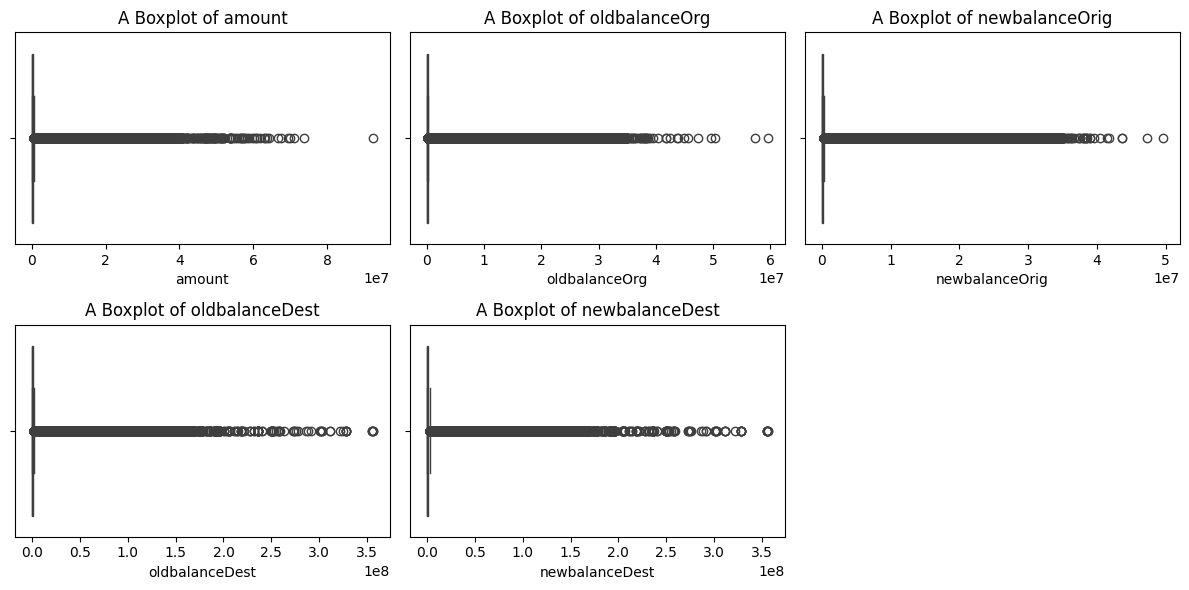

In [8]:
# Detecting presence of outliers
# Listing the numerical columns for a box plot
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Boxplot for numerical features
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=clean_fraud_df[col])
    plt.title(f"A Boxplot of {col}")
    plt.tight_layout()

plt.show()

There are presence of outliers which indecates this is a perfect dataset for fraud detection as we need to train the model to identify those extreme and unrealistic transactions. Therefore the outliers are kept for purpose of modelling using autoencoder and isolation.

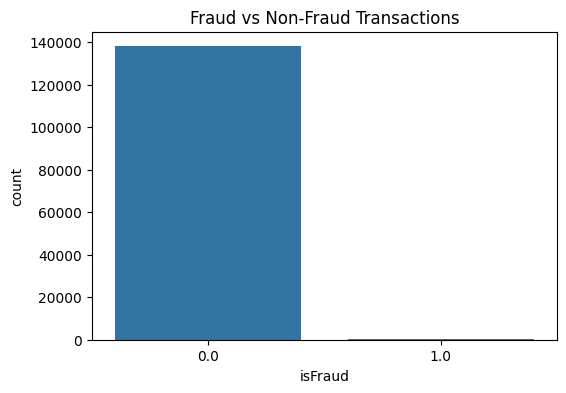

: 

: 

: 

: 

: 

In [ ]:
# visualizing the fraud vs non-fraud transactions
plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=clean_fraud_df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

There is imbalance between is fraud and is not fraud

In [ ]:
# Calculating fraud percentage
fraud_percentage = (clean_fraud_df['isFraud'].sum() / len(clean_fraud_df)) * 100

# Printing the percentage of fraud result
print(f"Fraud Percentage in the dataset: {fraud_percentage:.2f}%")

Fraud Percentage in the dataset: 0.09%


: 

: 

: 

: 

: 

#Feature Selection

In [ ]:
# Dropping unnecessary columns in the dataset
fraud_data = clean_fraud_df.drop(['nameOrig', 'nameDest'], axis=1)

# Converting transaction type to numerical
fraud_data['type'] = fraud_data['type'].astype('category').cat.codes

: 

: 

: 

: 

: 

In [ ]:
# # Splitting features  and target
# X = fraud_data.drop(columns=['isFraud'])
# y = fraud_data['isFraud']

# # Train a Random Forest model to check feature importance
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X, y)

# # Get feature importance
# feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
# feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

: 

: 

: 

: 

: 

In [ ]:
# print(feature_importance)

          Feature  Importance
2          amount    0.261731
3   oldbalanceOrg    0.230818
6  newbalanceDest    0.200462
5  oldbalanceDest    0.159863
0            step    0.083552
1            type    0.042793
4  newbalanceOrig    0.020781
7  isFlaggedFraud    0.000000


: 

: 

: 

: 

: 

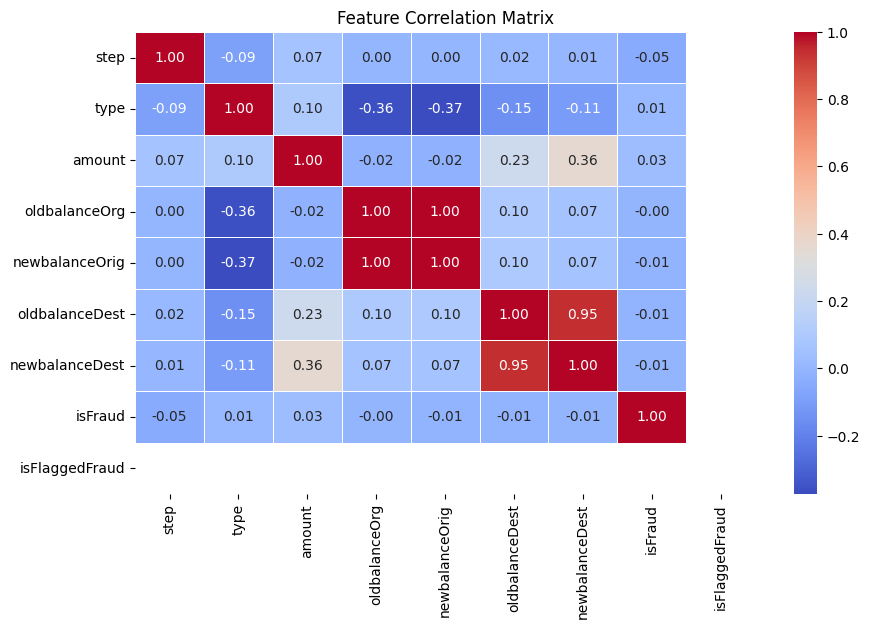

: 

: 

: 

: 

: 

In [ ]:
# # Computing the correlation matrix to further understand the importance of each feature
# corr_matrix = fraud_data.corr()

# # Plotting a heatmap of th correlated features
# plt.figure(figsize=(10, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("Feature Correlation Matrix")
# plt.show()

oldbalanceOrg vs newbalanceOrig as a high Correlation ≈ 1.00
oldbalanceDest vs newbalanceDest as high Correlation ≈ 0.96
isFlaggedFraud has almost no correlation with isFraud hence these features have less impact on modeling.

In [ ]:
# # Dropping the redundant features
# fraud_data_new = fraud_data.drop(columns=['newbalanceOrig', 'newbalanceDest', 'isFlaggedFraud'])


: 

: 

: 

: 

: 

In [ ]:
# Scalling numerical features
scaler = StandardScaler()
num_features = ['amount', 'oldbalanceOrg', 'oldbalanceDest', 'step']
fraud_data[num_features] = scaler.fit_transform(fraud_data[num_features])

# Display processed dataset
fraud_data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,-4.348368,3,-0.493308,-0.256904,160296.36,-0.380055,0.0,0.0,0.0
1,-4.348368,3,-0.516645,-0.309613,19384.72,-0.380055,0.0,0.0,0.0
2,-4.348368,4,-0.521570,-0.317072,0.00,-0.380055,0.0,1.0,0.0
3,-4.348368,1,-0.521570,-0.317072,0.00,-0.371179,0.0,1.0,0.0
4,-4.348368,3,-0.487958,-0.302425,29885.86,-0.380055,0.0,0.0,0.0


: 

: 

: 

: 

: 

#Splitting data into train and test

In [ ]:
# Define features (X) and target variable (y)
X = fraud_data.drop(columns=['isFraud'])
y = fraud_data['isFraud']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class distribution in train and test sets
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

isFraud
0.0    0.999113
1.0    0.000887
Name: proportion, dtype: float64
isFraud
0.0    0.999131
1.0    0.000869
Name: proportion, dtype: float64


: 

: 

: 

: 

: 

#Handling Imbalance

In [ ]:
# Using SMOTE SMOTE to balance the dataset
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Checking the new class distribution after handling the imbalance
print(y_train_sm.value_counts(normalize=True))

isFraud
0.0    0.833338
1.0    0.166662
Name: proportion, dtype: float64


: 

: 

: 

: 

: 

#Model Training and Evaluation

# 1. XGBoost, Random Forest, LightGBM and Logistic Regression

In [ ]:
# Initializing the models
models = {
    "XGBoost": XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
    "LightGBM": LGBMClassifier(is_unbalance=True),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000)
}

# Training and evaluating the models
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     27599
         1.0       0.42      0.67      0.52        24

    accuracy                           1.00     27623
   macro avg       0.71      0.83      0.76     27623
weighted avg       1.00      1.00      1.00     27623

ROC-AUC Score: 0.8329347681679287

Model: Random Forest
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     27599
         1.0       0.68      0.62      0.65        24

    accuracy                           1.00     27623
   macro avg       0.84      0.81      0.83     27623
weighted avg       1.00      1.00      1.00     27623

ROC-AUC Score: 0.8123731838110076
[LightGBM] [Info] Number of positive: 22078, number of negative: 110394
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

: 

: 

: 

: 

: 

2. Isolation Forest

In [ ]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]  # Convert anomalies to fraud

print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_iso))

Isolation Forest Results:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     27599
         1.0       0.00      0.04      0.01        24

    accuracy                           0.99     27623
   macro avg       0.50      0.52      0.50     27623
weighted avg       1.00      0.99      0.99     27623

ROC-AUC Score: 0.5159962015531965


: 

: 

: 

: 

: 

3. Autoencoder

In [ ]:
# Autoencoder model
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(X_train.shape[1], activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))

# Fraud detection based on reconstruction error
reconstruction_error = ((X_test - autoencoder.predict(X_test)) ** 2).mean(axis=1)
threshold = np.percentile(reconstruction_error, 95)  # Set threshold for fraud

y_pred_auto = [1 if e > threshold else 0 for e in reconstruction_error]

print("Autoencoder Results:")
print(classification_report(y_test, y_pred_auto))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_auto))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3453/3453 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2217593012224.0000 - val_loss: 2233982779392.0000
Epoch 2/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2222652391424.0000 - val_loss: 2233982779392.0000
Epoch 3/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2231142973440.0000 - val_loss: 2233982779392.0000
Epoch 4/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 2249920348160.0000 - val_loss: 2233982779392.0000
Epoch 5/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2196660420608.0000 - val_loss: 2233982779392.0000
Epoch 6/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2256600301568.0000 - val_loss: 2233982779392.0000
Epoch 7/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2252000460800.0000 - val_loss: 2233982779392.0000
Epoch 8/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2198679584768.0000 - val_loss: 2233982779392.0000
Epoch 9/10
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2261579464704.0000 - val_loss: 2233982779392.00

: 

: 

: 

: 

: 

In [ ]:
# Model performance data (from your results)
model_results = {
    "XGBoost": [1.00, 0.67, 0.52, 0.83],
    "Random Forest": [0.68, 0.62, 0.65, 0.81],
    "LightGBM": [0.37, 0.71, 0.49, 0.85],
    "Logistic Regression": [0.00, 0.75, 0.01, 0.79],
    "Isolation Forest": [0.00, 0.04, 0.01, 0.52],
    "Autoencoder": [0.00, 0.00, 0.00, 0.47]
}

# Convert to DataFrame
df_performance = pd.DataFrame(
    model_results, index=["Precision", "Recall", "F1-Score", "ROC-AUC"]
).T

# Calculate an overall score (Weighted Average of metrics)
weights = {"Precision": 0.2, "Recall": 0.3, "F1-Score": 0.3, "ROC-AUC": 0.2}
df_performance["Overall Score"] = df_performance.dot(pd.Series(weights))

# Identify the best model
best_model = df_performance["Overall Score"].idxmax()
best_score = df_performance["Overall Score"].max()

# Display ranked models
df_performance = df_performance.sort_values(by="Overall Score", ascending=False)
print(df_performance)

# Print the best model
print(f"\nThe best-performing model is **{best_model}** with an Overall Score of {best_score:.3f}")


                     Precision  Recall  F1-Score  ROC-AUC  Overall Score
XGBoost                   1.00    0.67      0.52     0.83          0.723
Random Forest             0.68    0.62      0.65     0.81          0.679
LightGBM                  0.37    0.71      0.49     0.85          0.604
Logistic Regression       0.00    0.75      0.01     0.79          0.386
Isolation Forest          0.00    0.04      0.01     0.52          0.119
Autoencoder               0.00    0.00      0.00     0.47          0.094

✅ The best-performing model is **XGBoost** with an Overall Score of 0.723


: 

: 

: 

: 

: 

In [ ]:
# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [0, 0.1, 0.5, 1]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(objective="binary:logistic", scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss")

# Perform Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    scoring="roc_auc",  # Optimize for AUC score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit to the dataset
random_search.fit(X_train, y_train)

# Display best parameters
print("Best Parameters:", random_search.best_params_)

# Get best model
best_xgb = random_search.best_estimator_

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Compute AUC Score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_prob)
print(f"Best XGBoost Model AUC Score: {auc_score:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best XGBoost Model AUC Score: 0.9809


: 

: 

: 

: 

: 

In [ ]:
# Define the best model with optimized parameters
best_xgb = xgb.XGBClassifier(
    subsample=0.6,
    reg_lambda=0.5,
    reg_alpha=1,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    random_state=42
)

# Define Stratified K-Fold Cross-Validation (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute AUC scores
cv_auc_scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring="roc_auc")

# Print mean and standard deviation of AUC scores
print(f"Mean AUC Score: {np.mean(cv_auc_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_auc_scores):.4f}")


Mean AUC Score: 0.9958
Standard Deviation: 0.0050


: 

: 

: 

: 

: 

The cross-validation results confirm the model's stability, with a high mean AUC score of 0.9958 and minimal variance (0.0050), making it reliable for deployment.

In [ ]:
import joblib

# Save the model
joblib.dump(best_xgb, 'Transaction_fraud_detect.pkl')

print("Model saved successfully.")


Model saved successfully.


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 